In [1]:
import numpy as np
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import concurrent.futures, itertools
import matplotlib.pyplot as plt
import pickle

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})


In [2]:
with open('/home/fverdian/class/soundspeed-scripts/1loop/Pk-lin-int.pkl', 'rb') as f:
    Plin_int = pickle.load(f)
fact=(2*np.pi)**3

def F3(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    kPq2 = k2 + q2 + 2*k*q*mu 

    res1 = 1/kMq2*(5/126*k2-11/108*k*q*mu+7/108*q2*mu2-1/54*k2*k2*mu2/q2+4/189*k2*k*mu2*mu/q-23/756*k2*k*mu/q+25/252*k2*mu2-2/27*k*q*mu2*mu)
    res2 = 1/kPq2*(5/126*k2+11/108*k*q*mu-7/108*q2*mu2-4/27*k2*k2*mu2/q2-53/189*k2*k*mu2*mu/q+23/756*k2*k*mu/q-121/756*k2*mu2-5/27*k*q*mu2*mu)
    return res1+res2

def F2(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    return (k2*(7*k*q*mu+3*q2)-10*k2*q2*mu2)/(14*q2*kMq2)

def alpha(k1,k2,cT):
    return 1+cT*k2/k1

def alphas(k1,k2,cT):
    return 1+0.5*cT*(k2/k1+k1/k2)

def beta(k1,k2,cT):
    t1=k1*k1+k2*k2+2*k1*k2*cT
    t2=k1*k2*cT
    t3=2.*k1*k1*k2*k2
    return t1*t2/t3


In [70]:
fx=0.1
fullt=np.linspace(-10,2, 100)
teval=0
idx_eta=np.abs(fullt - (0.)).argmin()
kref=0.1
supprshift=5

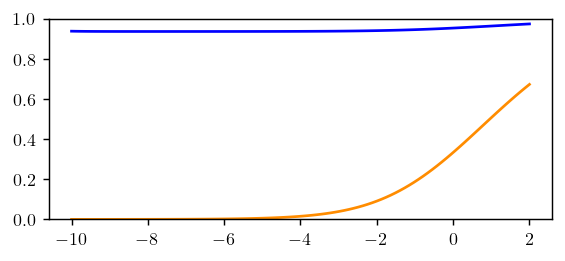

In [4]:
# this is solved fot k=0.1 (for which tildeeta = eta) and then I shift it using the smmetry
def lin_system(w,t):
    dc,Tc,dx,Tx = w
    ddcdt = Tc
    dTcdt = -0.5*Tc+1.5*(1-fx)*dc+1.5*fx*dx
    ddxdt = Tx
    dTxdt = -0.5*Tx+1.5*(1-fx)*dc+1.5*(fx-(1)*np.exp(-t))*dx -np.exp(-t-supprshift)*ddxdt
    return [ddcdt, dTcdt,ddxdt, dTxdt]
# Initial conditions
w0 = [1,1-3/5*fx,0.,0.]
# Solve the differential equation
tlin=np.linspace(fullt[0],fullt[-1],1000)

linsol = odeint(lin_system, w0, tlin)


g_c_int=interp1d(tlin,linsol[:,1]/linsol[:, 0],bounds_error=False,  fill_value=(1-3/5*fx,1))
phi_x_int=interp1d(tlin,linsol[:, 2]/linsol[:, 0],bounds_error=False, fill_value=(0.,1.))
g_x_int=interp1d(tlin,linsol[:, 3]/linsol[:, 0],bounds_error=False, fill_value=(0.,1.))
plt.figure(figsize=(5,2), dpi=130);plt.ylim([0,1])
plt.plot(fullt, g_c_int(fullt), 'b', label=r'$\Theta$')
plt.plot(fullt, phi_x_int(fullt), 'darkorange', label=r'$\delta_\chi$')
plt.show()

In [5]:
#--------
# 2nd order
#--------

def solve_second_order(triplet, return_timedep=False, inicond=False):
    k1 , k2, cT = triplet

    Fc2_0=(5./7.+6/245*fx)*alphas(k1,k2,cT)+(2./7.-6/245*fx)*beta(k1,k2,cT)
    Gc2_0=(3./7-51/245*fx)*alphas(k1,k2,cT)+(4./7-96/245*fx)*beta(k1,k2,cT)
    inicond=[Fc2_0,Gc2_0,0,0]

    def F2_system(w, t):
        Fc2,Gc2,Fx2,Gx2 = w
        fact=(g_c_int(t-2*np.log(k1/kref))+g_c_int(t-2*np.log(k2/kref)))
        SF2=0.5*g_c_int(t-2*np.log(k1/kref))*alpha(k1,k2,cT)+0.5*g_c_int(t-2*np.log(k2/kref))*alpha(k2,k1,cT)
        dGc2dt = -(0.5+fact)*Gc2 + 1.5 *((1-fx)*Fc2+fx*Fx2) +g_c_int(t-2*np.log(k1/kref))*g_c_int(t-2*np.log(k2/kref))*beta(k1,k2,cT)
        dFc2dt = -fact*Fc2 + Gc2 + SF2

        SF2=0.5*phi_x_int(t-2*np.log(k2/kref))*g_x_int(t-2*np.log(k1/kref))*alpha(k1,k2,cT)+0.5*phi_x_int(t-2*np.log(k1/kref))*g_x_int(t-2*np.log(k2/kref))*alpha(k2,k1,cT)
        dFx2dt = -fact*Fx2 + Gx2 + SF2
        dGx2dt = -(0.5+fact)*Gx2 + 1.5 *((1-fx)*Fc2+(fx-(k1**2+k2**2+2*k1*k2*cT)/(kref**2)*np.exp(-t))*Fx2) +g_x_int(t-2*np.log(k1/kref))*g_x_int(t-2*np.log(k2/kref))*beta(k1,k2,cT) -(k1**2+k2**2+2*k1*k2*cT)/(kref**2)*np.exp(-t-supprshift)*dFx2dt


        return [dFc2dt, dGc2dt,dFx2dt, dGx2dt]

    sol = odeint(F2_system, inicond, fullt, rtol=1.e-3)

    if return_timedep:
        return sol
    return sol[idx_eta]

-0.6350364448181212


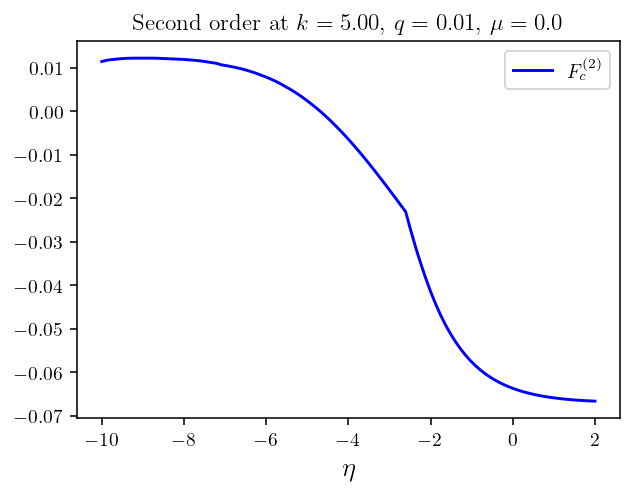

In [19]:
# kq=0.01
# x=1.e-4
# qp=np.sqrt(kq*x)
# kp=np.sqrt(kq/x)
kp=5
qp=0.01
mup=0.
kMq = np.sqrt(kp**2 + qp**2 - 2*kp*qp*mup)
cT12 = (kp*mup-qp)/kMq

sol=solve_second_order([qp,kMq,cT12], return_timedep=True)

plt.figure(figsize=(5,3.5), dpi=140)
plt.plot(fullt, sol[:,0]/F2(kp,qp,mup)-1, 'b', label=r'$F_c^{(2)}$')
# plt.plot(fullt, sol[:,2]/sol[:,0], 'm', label=r'$F_\chi^{(2)}$')
# plt.axhline(F2(kp,qp,mup), label='EdS')

Fc2_D=(5./14.+3/490*6*fx)*alpha(qp,kMq,cT12)+(5./14.-3/490*29*fx)*alpha(kMq,qp,cT12)+(2./7.-3/490*12*fx)*beta(qp,kMq,cT12)
# plt.axhline(Fc2_D, color='m')

print((solve_second_order([qp,kMq,cT12])[0]/F2(kp,qp,mup)-1)/fx)
plt.legend()
# plt.xlim([-8,8])

# plt.yscale('log')
plt.title(r'Second order at $k='+'%.2f'%kp+r'$, $q='+'%.2f'%qp+r'$, $\mu='+'%.1f'%mup+r'$')
plt.xlabel(r'$\eta$', fontsize=14)
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/F2_kers_eta.pdf', bbox_inches='tight')

plt.show()

In [7]:
xlist = np.logspace(-3,3,20)
mup=0.
kq=0.01
# x=q/k
def compute_forx(x):
    q=np.sqrt(kq*x)
    k=np.sqrt(kq/x)
    kMq = np.sqrt(k**2 + q**2 - 2*k*q*mup)
    cT12 = (k*mup-q)/kMq
    ret = solve_second_order([q,kMq,cT12])[0]
    return ret

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(compute_forx, xlist)
num_x = np.array(list(results))

limBx = num_x[-1]
limDx = num_x[0]
print(f'q from {np.sqrt(kq*xlist[0]):.1e} to {np.sqrt(kq*xlist[-1]):.1e} ')
print(f'k from {np.sqrt(kq/xlist[0]):.1e} to {np.sqrt(kq/xlist[-1]):.1e} ')

mock_x = (limDx - limBx)/(1+(xlist)**2)+limBx
EdS_x = F2(np.sqrt(kq/xlist),np.sqrt(kq*xlist),mup)

q from 3.2e-03 to 3.2e+00 
k from 3.2e+00 to 3.2e-03 


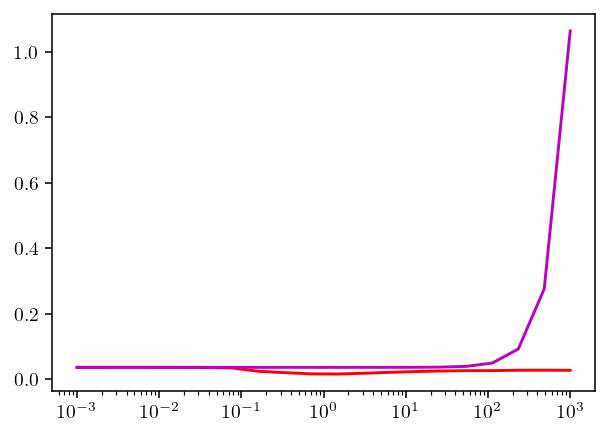

In [8]:
plt.figure(figsize=(5,3.5), dpi=140)
# plt.plot(xlist, num_x, 'b')
# plt.plot(xlist, mock_x, 'c')
# plt.plot(xlist, EdS_x, 'g')

plt.plot(xlist, num_x/EdS_x-1, 'r')
plt.plot(xlist, mock_x/EdS_x-1, 'm')

# plt.axhline(3/14)
# plt.axhline(3/14+18/245*fx)

plt.xscale('log')
plt.show()

In [31]:
Ngrid=20
numsol_grid = np.zeros((Ngrid,Ngrid))
logqgrid=np.linspace(-3,1,Ngrid)
mup=0.

def compute_heatmap_element(indices):
    i, j = indices
    k=10**(logqgrid[i])
    q=10**(logqgrid[j])
    kMq = np.sqrt(k**2 + q**2 - 2*k*q*mup)
    cT12 = (k*mup-q)/kMq
    ret = solve_second_order([q,kMq,cT12])[0]
    return i, j, ret

indices_list = list(itertools.product(range(Ngrid), range(Ngrid)))
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(compute_heatmap_element, indices_list)
for i, j, value in results:
    numsol_grid[i, j] = value

In [32]:
Dmockgrid = np.zeros((Ngrid,Ngrid))
EdS_grid = np.zeros((Ngrid,Ngrid))
for i in range(Ngrid):
    for j in range(Ngrid):
        k=10**(logqgrid[i])
        q=10**(logqgrid[j])
        EdS_grid[i, j] = F2(k,q,mup) 

minq=10**(logqgrid[0]);maxq=10**(logqgrid[-1])
limB = numsol_grid[0,-1]/EdS_grid[0,-1] -1
limC = numsol_grid[-1,-1]/EdS_grid[-1,-1] -1
limD = numsol_grid[-1,0]/EdS_grid[-1,0] -1

for i in range(Ngrid):
    for j in range(Ngrid):
        k=10**(logqgrid[i])
        q=10**(logqgrid[j])
        y=logqgrid[j]-np.log10(kref)
        x=logqgrid[i]-np.log10(kref)
        # limC=0.1
        # limD=0.4
        # limB=0.2
        # myfuncy = (limD - limB)/(1+10**(2*y))+limB 
        # myfuncx = 1/(1+x**2)
        myfunc=np.exp(4*y)*(limC*np.exp(4*x)+limB)+limD*np.exp(4*x)
        myfunc/= ((np.exp(4*x)+1)*(np.exp(4*y)+1))
        Dmockgrid[i, j] =myfunc
        # Dmockgrid[i, j] = (y**2)/(1+y**2)*myfuncx



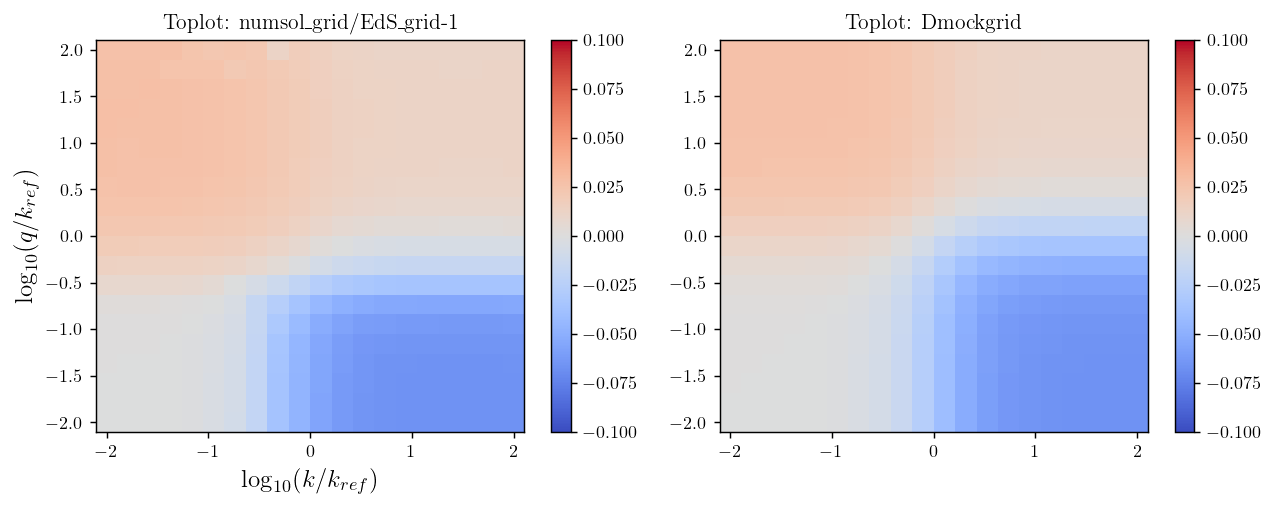

In [34]:
# X, Y = np.meshgrid(10**logqgrid, 10**logqgrid)
X, Y = np.meshgrid(logqgrid-np.log10(kref), logqgrid-np.log10(kref))
# X, Y = np.meshgrid(0.5-1/(1+np.exp(logqgrid-np.log10(kref))),0.5-1/(1+np.exp(logqgrid-np.log10(kref))))

# plt.pcolormesh(X, Y,heatmap_sampled.T, cmap='coolwarm', vmax=np.max(np.abs(heatmap_sampled)), vmin=-np.max(np.abs(heatmap_sampled)))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=130)
toplot= numsol_grid/EdS_grid-1
# First plot
c1 = ax1.pcolormesh(X, Y, toplot.T, cmap='coolwarm', vmin=-0.1, vmax=0.1)
fig.colorbar(c1, ax=ax1)
ax1.set_xlabel(r"$\log_{10}(k/k_{ref})$", fontsize=14)
ax1.set_ylabel(r"$\log_{10}(q/k_{ref})$", fontsize=14)
ax1.set_title("Toplot: numsol_grid/EdS_grid-1")

# Second plot
c2 = ax2.pcolormesh(X, Y, Dmockgrid.T, cmap='coolwarm', vmin=-0.1, vmax=0.1)
fig.colorbar(c2, ax=ax2)
ax1.set_xlabel(r"$\log_{10}(k/k_{ref})$", fontsize=14)
ax1.set_ylabel(r"$\log_{10}(q/k_{ref})$", fontsize=14)
ax2.set_title("Toplot: Dmockgrid")

plt.tight_layout()
plt.show()

Limid A: 2.0819058144156436e-05 -2.405154779550056e-05 0
Limid B: 0.02713976007612956 0.02715443707173093 0.02715443707173093
Limid C: 0.010539154391735927 0.010525394718575942 0.010525394718575942
Limid D: 0.034924513073807846 0.034944414809510604 0.034944414809510604
0.22163265306122448
0.034944414809510604


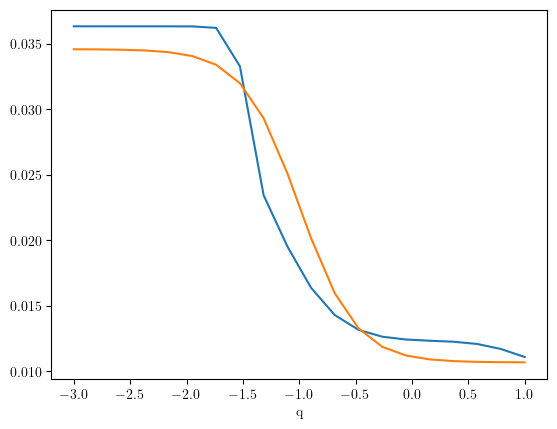

In [83]:
print('Limid A:',(Dmockgrid)[0,0], (numsol_grid/EdS_grid)[0,0]-1, 0)
print('Limid B:',(Dmockgrid)[0,-1], (numsol_grid/EdS_grid)[0,-1]-1, limB)
print('Limid C:', (Dmockgrid)[-1,-1], (numsol_grid/EdS_grid)[-1,-1]-1,limC)
print('Limid D:',(Dmockgrid)[-1,0], (numsol_grid/EdS_grid)[-1,0]-1, limD)

print(3/14+18/245*fx)
print(limD)

kidx=15
plt.plot(logqgrid, numsol_grid[kidx,:]/EdS_grid[kidx,:]-1)
plt.plot(logqgrid, Dmockgrid[kidx,:])


plt.xlabel('q')
plt.show()

----
fuori tema, generare linear level with class

In [4]:
from classy import Class
from scipy.optimize import brentq

common_settings = {
'perturbations_verbose':0,
'background_verbose':2,
'output':'mTk, vTk, mPk',
'gauge':'newtonian',
'P_k_max_1/Mpc':200,
'z_max_pk':100,
'format':'class',
'N_ur': 3.046,

# Planck pars
'h':0.6736,
'A_s': 2.100e-09,
'n_s': 0.9649 
}

# pass input parameters
# SET THE PARAMETERS AS THERE VARIABLES
fx=0.1
kref=0.4
zeval=1. #Forced to 1 if I use the relation for aNR


In [5]:
# FIND aNR by shooting
shootCDM = Class()
shootCDM.set({'h':0.67810,'z_reio':7.6711,'YHe':0.25,'omega_b':0.022,'omega_cdm':(1-fx)*0.142-0.022,'f_chi':fx,'cs2_peak_chi':1./3.,'background_verbose':0,'output':''})

def find_aNR_byshoot(log10aNR):
    shootCDM.set({
    'acs_chi':10**log10aNR,
    })
    shootCDM.compute()
    shootCDMbck = shootCDM.get_background() # load background table
    kJ_int_z=interp1d(shootCDMbck['z'],shootCDMbck['(.)kJ_chi'])
    return kJ_int_z(1.) - kref
aNR = 10**(float(brentq(find_aNR_byshoot, -5, 0)))
print(f'The value of aNR that gives kref={kref} is {aNR:.2e}')

The value of aNR that gives kref=0.4 is 6.95e-04


In [6]:
chiCDM = Class()
chiCDM.set(common_settings)

chiCDM.set({
'omega_b':0.022,
# set total matter to omega_m=0.142
'omega_cdm':(1-fx)*0.142-0.022,
'f_chi':fx,
'acs_chi':aNR,
'cs2_peak_chi':1./3.,
# 'T_cmb':1.8,
})
chiCDM.compute()

#get the growth factor of a LCDM equivalent
pureCDM = Class()
pureCDM.set(common_settings)
pureCDM.set({
    'omega_cdm': 0.12,
    'omega_b':0.022,
})
pureCDM.compute()

background = chiCDM.get_background() # load background table
kJ_chi=background['(.)kJ_chi']
kJ_int_z=interp1d(background['z'],kJ_chi)
print(f'For aNR={aNR} we have kJ(z=1)={kJ_int_z(1.)}')


Running CLASS version v3.2.0
Computing background
Chose ndf15 as generic_evolver
 -> age = 13.824146 Gyr
 -> conformal age = 14189.122158 Mpc
 -> N_eff = 3.046 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3393.117217
    corresponding to conformal time = 113.127300 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0484862       , omega = 0.022          
-> Cold Dark Matter               Omega = 0.233175        , omega = 0.1058         
-> Dark Matter with sound speed:  Omega = 0.0312957       , omega = 0.0142         
 ---> Relativistic Species 
-> Photons                        Omega = 5.45025e-05     , omega = 2.47298e-05    
-> Ultra-relativistic relics      Omega = 3.77031e-05     , omega = 1.71073e-05    
 ---> Other Content 
-> Cosmological Constant          Omega = 0.686951        , omega = 0.311695       
 ---> Total bud

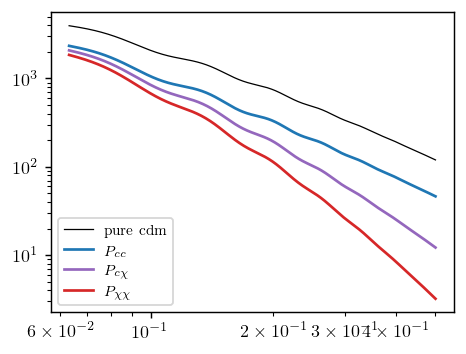

In [6]:
kk = np.logspace(-1.2,np.log10(0.5),500) # k in h/Mpc
Pk_chi = [] # P(k) in (Mpc/h)**3
Pk_cdm = [] # P(k) in (Mpc/h)**3

h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc
for k in kk:
    Pk_chi.append(chiCDM.pk_cb_lin(k*h,zeval)*h**3) # function .pk(k,z)
    Pk_cdm.append(pureCDM.pk_lin(k*h,zeval)*h**3) # function .pk(k,z)
Pk_chi=np.array(Pk_chi);Pk_cdm=np.array(Pk_cdm)

PLc_int=interp1d(kk,Pk_chi,fill_value='extrapolate')

plt.figure(figsize=(4,3), dpi=130)
plt.loglog(kk, Pk_cdm,'k',label=r'pure cdm', linewidth=0.7)
plt.plot(kk, Pk_chi,'tab:blue',label=r'$P_{cc}$')

gkk=1/(1+2*(kk/kref)**1.5)
plt.plot(kk, Pk_chi*gkk,'tab:purple',label=r'$P_{c\chi}$')
plt.plot(kk, Pk_chi*gkk*gkk,'tab:red',label=r'$P_{\chi\chi}$')

plt.legend(loc='lower left',fontsize=8)
plt.show()

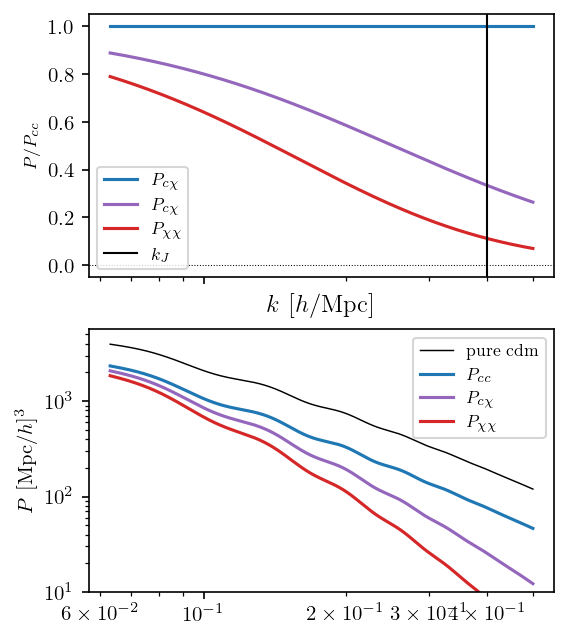

In [7]:
fig, axs = plt.subplots(2, 1, sharex=True,gridspec_kw={'height_ratios': [1.,1.]}, figsize=(4,5), dpi=150)
# Upper plot

axs[1].loglog(kk, Pk_cdm,'k',label=r'pure cdm', linewidth=0.7)
axs[1].plot(kk, Pk_chi,'tab:blue',label=r'$P_{cc}$')

gkk=1/(1+2*(kk/kref)**1.5)
axs[1].plot(kk, Pk_chi*gkk,'tab:purple',label=r'$P_{c\chi}$')
axs[1].plot(kk, Pk_chi*gkk*gkk,'tab:red',label=r'$P_{\chi\chi}$')

axs[0].plot(kk, kk**0,'tab:blue',label=r'$P_{c\chi}$')
axs[0].plot(kk, gkk,'tab:purple',label=r'$P_{c\chi}$')
axs[0].plot(kk, gkk*gkk,'tab:red',label=r'$P_{\chi\chi}$')
axs[0].axvline(0.4,color='k',linewidth=1.,label=r'$k_J$')

# Aggiunte e regolazioni finali
axs[1].set_ylabel(r"$P$ $[\mathrm{Mpc}/h]^3$", fontsize=10)
axs[1].set_ylim([10,None])
axs[1].set_xscale('log')
axs[1].legend(fontsize=8, ncol=1)

axs[0].set_ylabel(r"$P/P_{cc}$", fontsize=8)
axs[0].axhline(0, linestyle=":",color='k', linewidth=0.5)

axs[0].set_xlabel(r"$k$ [$h/\mathrm{Mpc}$]", fontsize=12)
axs[0].set_xscale('log')
axs[0].legend(fontsize=8)

# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/P-lin-chicross.pdf', bbox_inches='tight')

plt.show()

0.24495984983776828


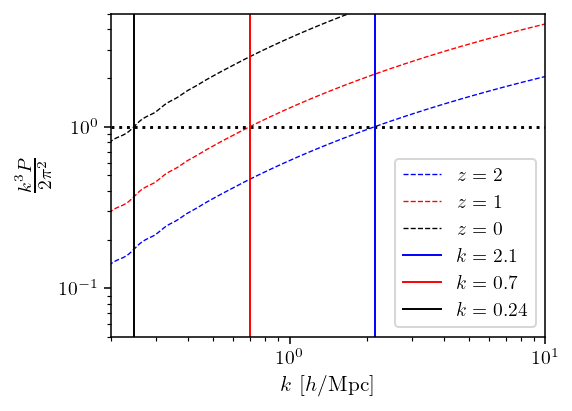

In [7]:
from scipy.optimize import brentq
kk = np.logspace(-2,np.log10(10),500) # k in h/Mpc
Pk_1 = [] # P(k) in (Mpc/h)**3
Pk_2 = [] # P(k) in (Mpc/h)**3
Pk_3 = [] # P(k) in (Mpc/h)**3

h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc
for k in kk:
    Pk_1.append(pureCDM.pk_lin(k*h,0.)*h**3) # function .pk(k,z)
    Pk_2.append(pureCDM.pk_lin(k*h,1.)*h**3) # function .pk(k,z)
    Pk_3.append(pureCDM.pk_lin(k*h,2.)*h**3) # function .pk(k,z)


Pk_1=np.array(Pk_1);Pk_2=np.array(Pk_2);Pk_3=np.array(Pk_3)

Pk_int=interp1d(kk,Pk_1)

def equation_to_solve(k):
    return Pk_int(k)*(k**3)/2/(np.pi**2) - 1
root = brentq(equation_to_solve, 1.e-2, 10)
print(root)

# results: z=1 -> kNL=0.28677; 
plt.figure(figsize=(4,3.), dpi=140)
plt.plot(kk, Pk_3*(kk**3)/2/(np.pi**2),'b--',label=r'$z=2$',linewidth=0.7)
plt.plot(kk, Pk_2*(kk**3)/2/(np.pi**2),'r--',label=r'$z=1$',linewidth=0.7)
plt.loglog(kk, Pk_1*(kk**3)/2/(np.pi**2),'k--',label=r'$z=0$', linewidth=0.7)

plt.axhline(1,color='k', linestyle=':')
plt.axvline(2.16,color='b', linewidth=1.,label=r'$k=2.1$')
plt.axvline(0.6958,color='r', linewidth=1.,label=r'$k=0.7$')
plt.axvline(0.245,color='k', linewidth=1.,label=r'$k=0.24$')

plt.xlim([0.2,10])
plt.ylim([0.05,5])

plt.legend(loc='best',fontsize=10)
plt.xlabel(r"$k$ [$h/\mathrm{Mpc}$]", fontsize=11)
plt.ylabel(r"$\frac{k^3P}{2\pi^2}$", fontsize=14)

plt.show()

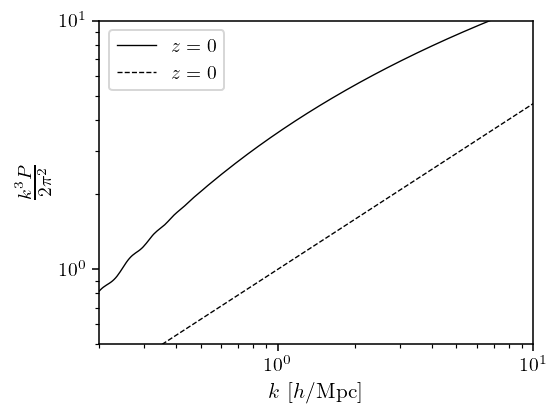

In [16]:
from scipy.optimize import brentq
kk = np.logspace(-2,np.log10(10),500) # k in h/Mpc
Pk_1 = [] # P(k) in (Mpc/h)**3

h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc
for k in kk:
    Pk_1.append(pureCDM.pk_lin(k*h,0.)*h**3) # function .pk(k,z)

Pk_1=np.array(Pk_1)

Pk_int=interp1d(kk,Pk_1)


# results: z=1 -> kNL=0.28677; 
plt.figure(figsize=(4,3.), dpi=140)
plt.loglog(kk, Pk_1*(kk**3)/2/(np.pi**2),'k',label=r'$z=0$', linewidth=0.7)
plt.loglog(kk, kk**(2/3),'k--',label=r'$z=0$', linewidth=0.7)

plt.xlim([0.2,10])
plt.ylim([0.5,10])

plt.legend(loc='best',fontsize=10)
plt.xlabel(r"$k$ [$h/\mathrm{Mpc}$]", fontsize=11)
plt.ylabel(r"$\frac{k^3P}{2\pi^2}$", fontsize=14)

plt.show()

---

In [3]:
import sys
sys.path.append('/home/fverdian/class/soundspeed-scripts/kernels-fullnum/numerical-integrals')
from num_kernels import NumKernels, PLfromClass
fx=0.1
t_ini = -6
fullt=np.linspace(t_ini,10, 200)
teval=0
kref=1
supprshift=5
nk = NumKernels(fx=fx, kref=kref, fullt=fullt, rtol=0.0001)

In [12]:
kp=20
qp=0.01
mup=0.0
kMq = np.sqrt(kp**2 + qp**2 - 2*kp*qp*mup)
cT12 = (kp*mup-qp)/kMq

sol=nk.solve_F2([qp,kMq,cT12], return_timedep=True)
print(fullt.shape, sol.shape)
solint=[interp1d(fullt, sol[:, i], kind='linear') for i in range(sol.shape[1])]

(200,) (200, 4)


In [16]:
print(np.array([solint(0.2) for solint in solint]))


[ 0.20007992 -0.08157645  0.00055115 -0.00138115]


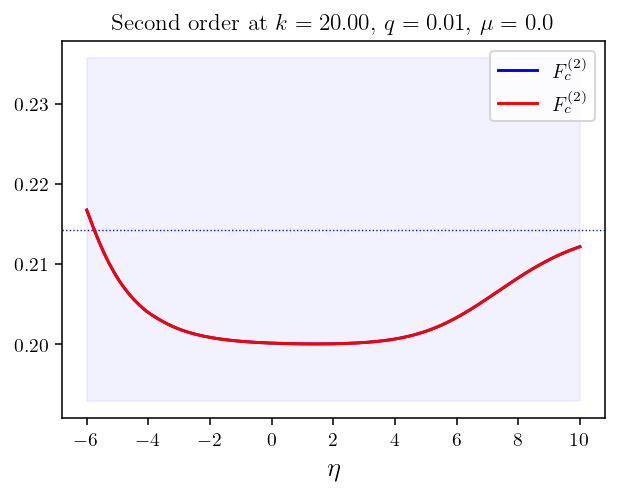

In [13]:

plt.figure(figsize=(5,3.5), dpi=140)
plt.plot(nk.fullt, sol[:,0], 'b', label=r'$F_c^{(2)}$')

plt.plot(nk.fullt,solint[0](fullt), 'r', label=r'$F_c^{(2)}$')

plt.axhline(nk.F2_0(kp,qp,mup), color='b', linestyle=':', linewidth=0.7)
# plt.axhline(F2(kp,qp,mup)+fx*DeltaF2q_Mq__midlim(kp,qp,mup)[0], color='m', linewidth=0.7)
plt.fill_between(fullt, nk.F2_0(kp,qp,mup)*(1-fx),nk.F2_0(kp,qp,mup)*(1+fx), alpha=0.05, color='b')

plt.legend()
plt.title(r'Second order at $k='+'%.2f'%kp+r'$, $q='+'%.2f'%qp+r'$, $\mu='+'%.1f'%mup+r'$')
plt.xlabel(r'$\eta$', fontsize=14)
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/F2_kers_eta.pdf', bbox_inches='tight')
plt.show()